In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# Load datasets
filepath_train_test = './train_test_data/dataset.csv'
filepath_validation = "./validation_data/dataset.csv"

df = pd.read_csv(filepath_train_test)
df_validation = pd.read_csv(filepath_validation)


In [2]:
# Aligning the datasets

# Find the difference in columns
unique_to_df1 = df.columns.difference(df_validation.columns)
unique_to_df2 = df_validation.columns.difference(df.columns)

# Drop the unique columns from each dataframe and sort columns
df = df.drop(columns=unique_to_df1)
df_validation = df_validation.drop(columns=unique_to_df2)
df_validation = df_validation[df.columns]

df.drop('_time', axis=1, inplace=True)
df_validation.drop('_time', axis=1, inplace=True)

In [3]:
# Prepare datasets for modeling and prediction

# Get X and y
y = df['5xx_lag_agg']
X = df.drop('5xx_lag_agg', axis=1)

# Get X and y for validation set
y_val = df_validation['5xx_lag_agg']
X_val = df_validation.drop('5xx_lag_agg', axis=1)

# Perform the train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# # Use SMOTE for oversampling minority classes
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [4]:
# Obtain the best performing metric from each category of data sources

# Use basic model
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for feature importances
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Define the prefixes
prefixes = ['app', 'res', 'net', 'log']

# Find the best feature for each prefix
best_features = {}
for prefix in prefixes:
    # Filter features by prefix
    prefix_features = features_df[features_df['Feature'].str.startswith(prefix)]
    
    # Find the feature with the highest importance in this category
    if not prefix_features.empty:
        best_feature = prefix_features.loc[prefix_features['Importance'].idxmax()]
        best_features[prefix] = best_feature

top_feature_names_list = []

# Display the best features from each category
for category, feature in best_features.items():
    print(f"Best feature in {category}: {feature['Feature']} with importance {feature['Importance']}")
    top_feature_names_list.append(feature['Feature'])

Best feature in app: app_app1_ofiles with importance 0.08783321308810162
Best feature in res: res_httpd_mempct with importance 0.0639703104589543
Best feature in net: net_db_rx with importance 0.000974503153607706
Best feature in log: log_app1_error5m with importance 0.05108831563977316


In [5]:
# Using only the top performing feature from each category

# Update the selected features
X_train = X_train[top_feature_names_list]
X_test = X_test[top_feature_names_list]
X_val = df_validation[top_feature_names_list]

# Initialize the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the model
rf.fit(X_train, y_train)

test_set = [X_test, y_test]
val_set = [X_val, y_val]

for dataset, name in zip([test_set, val_set], ["test_set", "val_set"]):
    y_pred = rf.predict(dataset[0])

    print("\nDataset: ", name)
    print("\nAccuracy:", accuracy_score(dataset[1], y_pred))
    print(classification_report(dataset[1], y_pred))
    f1_macro = f1_score(dataset[1], y_pred, average='macro')
    print("Macro-Averaged F1-Score:", f1_macro)
    y_prob = rf.predict_proba(dataset[0])
    roc_auc = roc_auc_score(dataset[1], y_prob, multi_class='ovr')
    print("\nAUC-ROC:", roc_auc)
    print("\nConfusion Matrix:")
    print(confusion_matrix(dataset[1], y_pred))


Dataset:  test_set

Accuracy: 0.9259259259259259
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       262
           1       0.84      0.90      0.87        82
           2       0.85      0.89      0.87        71
           3       0.97      0.98      0.97        98

    accuracy                           0.93       513
   macro avg       0.91      0.92      0.91       513
weighted avg       0.93      0.93      0.93       513

Macro-Averaged F1-Score: 0.9139518207801838

AUC-ROC: 0.9867078906780609

Confusion Matrix:
[[242  11   9   0]
 [  8  74   0   0]
 [  2   3  63   3]
 [  0   0   2  96]]

Dataset:  val_set

Accuracy: 0.5608028335301063
              precision    recall  f1-score   support

           0       0.97      0.41      0.57      1584
           1       0.46      0.87      0.60       454
           2       0.11      0.56      0.18       133
           3       0.99      0.83      0.91       370

    accuracy             

In [6]:
# Grid search cross validation
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 60, 70, 80, 90, 100, 200],
    'max_depth': [5, 10, 20, 30, 50],
    'min_samples_split': [2, 4, 6, 10],
    'min_samples_leaf': [1, 2, 4, 5, 7],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}


# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Initialize the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 5600 candidates, totalling 16800 fits
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=   0.1s
[CV] END bootstrap=True, criterion

In [7]:
# Use the best parameters from the grid search
# {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 60}
# best_params = grid_search.best_params_
best_params = {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 60}
rf = RandomForestClassifier(**best_params, random_state=0)

rf.fit(X_train, y_train)

# Make predictions and evaluate
for dataset, name in zip([test_set, val_set], ["test_set", "val_set"]):
    y_pred = rf.predict(dataset[0])

    print("\nDataset: ", name)
    print("\nAccuracy:", accuracy_score(dataset[1], y_pred))
    print(classification_report(dataset[1], y_pred))
    f1_macro = f1_score(dataset[1], y_pred, average='macro')
    print("Macro-Averaged F1-Score:", f1_macro)
    y_prob = rf.predict_proba(dataset[0])
    roc_auc = roc_auc_score(dataset[1], y_prob, multi_class='ovr')
    print("\nAUC-ROC:", roc_auc)
    print("\nConfusion Matrix:")
    print(confusion_matrix(dataset[1], y_pred))



Dataset:  test_set

Accuracy: 0.9278752436647173
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       262
           1       0.85      0.90      0.88        82
           2       0.85      0.90      0.88        71
           3       0.97      0.98      0.97        98

    accuracy                           0.93       513
   macro avg       0.91      0.93      0.92       513
weighted avg       0.93      0.93      0.93       513

Macro-Averaged F1-Score: 0.9171763760806939

AUC-ROC: 0.9875359715252916

Confusion Matrix:
[[242  11   9   0]
 [  8  74   0   0]
 [  2   2  64   3]
 [  0   0   2  96]]

Dataset:  val_set

Accuracy: 0.5596221959858324
              precision    recall  f1-score   support

           0       0.97      0.41      0.58      1584
           1       0.53      0.84      0.65       454
           2       0.09      0.56      0.15       133
           3       0.99      0.84      0.91       370

    accuracy             

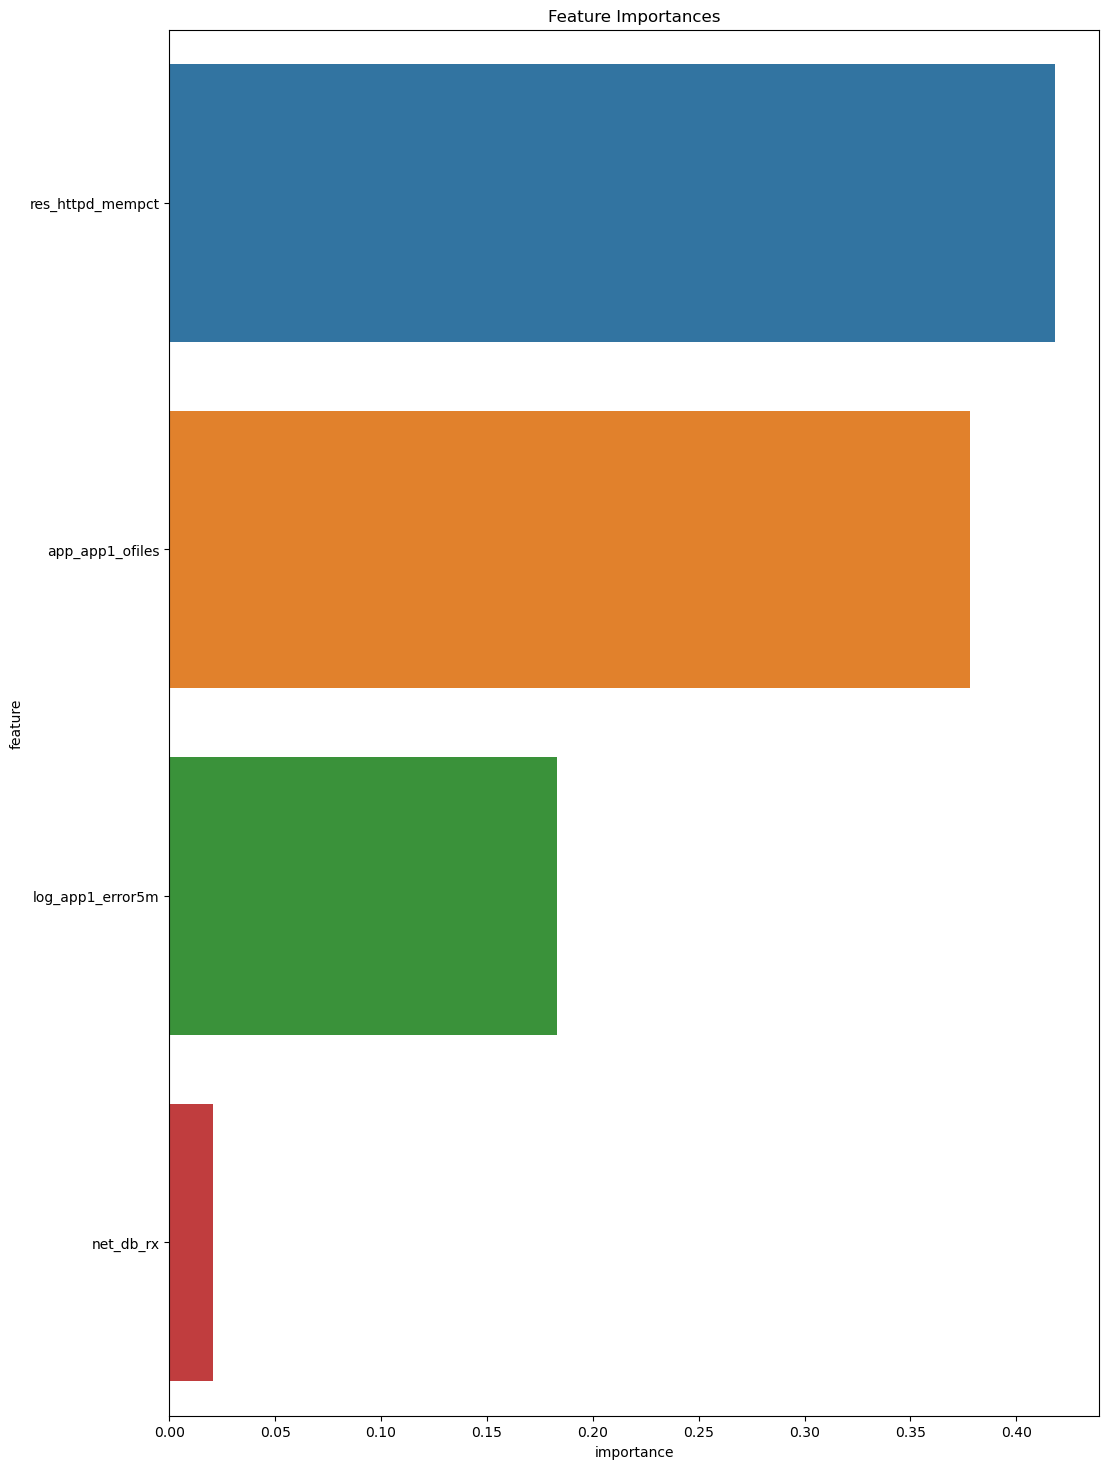

In [8]:
feature_importances = rf.feature_importances_

feature_names = X_val.columns
importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

importances = importances.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 18))
sns.barplot(x='importance', y='feature', data=importances)
plt.title('Feature Importances')
plt.show()